### Goal ###
Use geopandas and shapely to extract California as polygon from [US Census Bureau data](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). Then divide California into latitude, longitude bins to map weather and wild fire data onto. General strategy will be to make a rectangular set of points encompassing California and then keep only those that are actualy in California.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from shapely.geometry import MultiPolygon, Polygon, Point
%matplotlib inline

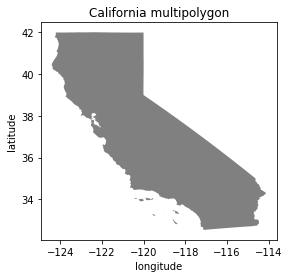

In [2]:
gdf = gpd.read_file('../data/spatial_data/cb_2018_us_state_500k.shp')
california = gdf[gdf['NAME'] == 'California']
california_polygon_plot = california.plot(color = 'gray')
california_polygon_plot = california_polygon_plot.set(
    title = "California multipolygon", 
    xlabel = "longitude", 
    ylabel = "latitude")

Note the difference between *geopandas.geoseries.GeoSeries* and *shapely.geometry.multipolygon.MultiPolygon* objects due to how the geopandas object is accessed. We need a MultiPolygon to move forwards. Go ahead and ask me how long it took to figure that out.

In [3]:
geoseries = california.loc[[16],'geometry']
type(geoseries)

geopandas.geoseries.GeoSeries

In [4]:
multipoly = california.loc[16, 'geometry']
type(multipoly)

shapely.geometry.multipolygon.MultiPolygon

In [5]:
type(multipoly[0])

shapely.geometry.polygon.Polygon

Now we have the several polygons which make up California in a list like multipolygon. For simplicity, we will keep only the large contiguous land mass and discard small islands. To do that, we will manualy check the area of each individual polygon and keep the largest.

In [6]:
for poly in multipoly:
    print(poly.area)

0.019012085881496932
0.014507036749999744
0.00030809267399790213
0.0003369923449999978
0.005691559857000079
0.024673631274499796
0.020933232845499895
0.0037961882335000537
0.0002749976010000293
0.0003275753844996651
8.810110100007037e-05
7.58171100012155e-06
41.57831615003242


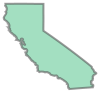

In [7]:
california = multipoly[-1]
california

In [8]:
type(california)

shapely.geometry.polygon.Polygon

Sanity check passes, last polygon in the list is what we are after, extracted it to as single polygon *california*.

Now we need a set of points based on the north-south, east-west extent of california. Will start with very course bins to get everything working. 

**Note:** I will follow the convention of writing latitude and longitude as cartisian coordinates (x, y). This is reversed relative to latitude and longitude conventions.

In [9]:
lat_start = 32.52
long_start = -124.48
lat_end = 42.0
long_end = -114.131
bin_width = .5
lat_coord = lat_start + bin_width
long_coord = long_start + bin_width

with open("../data/spatial_data/bins.csv","w") as output:
    output.write("long,lat\n")

    while lat_coord < lat_end:
            long_coord = long_start + bin_width

            while long_coord < long_end:
                output.write(f"{round(long_coord, 2)},{round(lat_coord, 2)}\n")
                long_coord += bin_width

            lat_coord += bin_width

output.close()

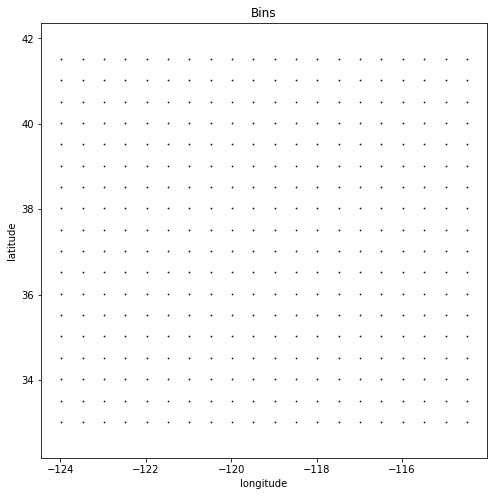

In [10]:
bins = pd.read_csv('../data/spatial_data/bins.csv')
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = bins['long'], y = bins['lat'], color = 'black', s = 0.5)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Bins')
plt.show()

Now lets get rid of bins that don't fall in our *california* polygon. This cell looks a bit complicated because it uses multiprocessing to farm work out to all avalible threads so we can work with large numbers of bins

In [11]:
# set number of worker processes
n_threads = 14

# empty series to be returned in place of a point
# which is outside of californa
empty = pd.Series([np.nan, np.nan ])
empty.index = ['long', 'lat']

def point_in_california(point):
    '''Takes point and returns point if in california'''
    coord = Point(point['long'], point['lat'])
    if coord.within(california) == True:
        return point
    else:
        return empty
    
def cull_points(points):
    '''Takes a dataframe containing long, lat points and 
    uses apply find points which fall in California'''
    keepers = points.apply(point_in_california, axis=1)
    return keepers
    
def parallelize(df, func, n_cores = n_threads):
    '''Parallelizes point picking, takes dataframe of points
    and splits up the cull fuction over avalibile threads'''
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

keeper_bins = parallelize(bins, cull_points).dropna()
keeper_bins.to_csv('../data/spatial_data/california_bins.csv', index = None, header = True)

**Note:** In testing this step is not great in terms of compute time. Setting bin width to 0.01 degrees results in just under a million bins and takes an average of 2.40 minutes to cull with 14 threads. On the bright side, this step should not have to run often. For now we will move forwards with an extremely course testing bin width of 0.25 degrees which results in ~660 bins. 

Plot keeper bins for sanity check.

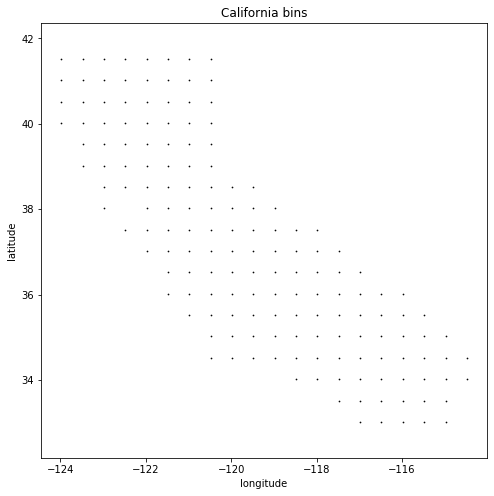

In [12]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = keeper_bins['long'], y = keeper_bins['lat'], color = 'black', s = 0.5)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California bins')
plt.show()

Success, looks like California!

### Next steps ###
1. Cull 1.88 million wild fires dataset. The orignal data set includes fires from the whole US.
2. Find nearest CDEC weather monitoring station to each bin.
3. For each time step between 2011 and 2016 assign weather data to bin from nearest station
4. For each time step between 2011 and 2016 assign fire data to each bin. This includes time since most recent fire and total recoreded fires.